<a href="https://colab.research.google.com/github/WojciechMojsiejuk/Artificial_Intelligence_SEOULTECH/blob/main/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment #3

* Release date: 2022/10/25 Tue
* Due date: **2022/11/01 Tue 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 10% (total 100 pts)

* We will train CNN using `dogs_vs_cats_subset.zip` distributed in the class.

> ### (5pts) Prepare the dataset

* Place the unzipped files in some directory on your Colab instance.
* Count the number of JPEG files in `train`, `validation`, and `test` folders.

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# unzip
import zipfile, os

path_to_zip = '/content/gdrive/MyDrive/Artificial_Intelligence/dogs_vs_cats_subset.zip'
dst_path = '/content/gdrive/MyDrive/Artificial_Intelligence/dataset'

if not os.path.exists(dst_path):
  os.makedirs(dst_path)
  with zipfile.ZipFile(path_to_zip, 'r') as file:
    file.extractall(dst_path)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = os.path.join(dst_path, 'subset/train')
test_path = os.path.join(dst_path, 'subset/test')
validation_path = os.path.join(dst_path, 'subset/validation')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_path,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


There is 2000 images in training folder, and 1000 images in test and validation folders each.

data batch shape: (20, 128, 128, 3)
labels batch shape: (20, 2)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


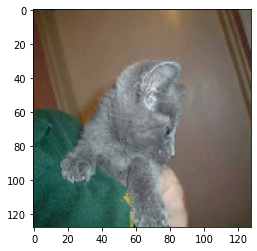

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  plt.imshow(image.array_to_img(data_batch[0]))
  print(labels_batch)
  break
  

> ### (20pts) Build a baseline model

* **(10pts)** Use VGG16 model as a baseline model.
  * You can use `tensorflow.keras.applications` module to get the VGG16 architecture.
  * You should customize the VGG16 model to deal with a given task, i.e., two class classification.
  * We will use 128*128 resized images as inputs to the model and randomly initialized model parameters.
  * Place **two output nodes** at the output layer.
  * Others not specified should be chosen yourself.

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights=None, # randomly initialized parameters
                  include_top=False,
                  input_shape=(128, 128, 3))

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax')) # because we need to have two nodes as an output we must use softmax activation function, rather then sigmoid used for 1 

* **(10pts)** How many trainable parameters in the first convolutional layer? Explain how to compute the number of parameters.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

We can see that for the first convolution layer we have 1792 parameters. Let's get this layer and check its configuration

In [ ]:
first_layer = conv_base.get_layer('block1_conv1')

In [ ]:
first_layer.kernel_size

(3, 3)

In [ ]:
first_layer.input.shape

TensorShape([None, 128, 128, 3])

In [ ]:
first_layer.output.shape

TensorShape([None, 128, 128, 64])

To compute numbers of parameters we must know the size of the kernel, size of the filter in the previous element of the model (input of this layer). After multiplying those three values we must add 1 for bias, and then finally multiply everything for the filter of this layer (which goest to the layer output)
[Source](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d)

In [ ]:
((first_layer.kernel_size[0] * first_layer.kernel_size[1] * first_layer.input.shape[3]) + 1 ) * first_layer.output.shape[3]

1792

As we can see, we obtained the same number

> ### (10pts) Train a baseline model 

  * Currently, the data is stored as JPEG files. So we need the following steps:
    * Read the files.
    * Decode the JPEG content to RGB grids of pixels.
    * Convert these into floating-point tensors.
    * Scaling the data to be in a range of [0,1].
    
  * Set `batch_size` to 20.
  * Train the network for 50 epochs. It may consume some time. Note that you should set `steps_per_epoch` and `validation_steps` properly so that a particular data is processed once during a single epoch.
  * **Use Adam optimizer to train the model**. You may need to find hyperparameters (e.g., learning rate) to make the optimizer work.
  * Here, you don't need to apply any regularization methods. 

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5,), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
100/100 [==============================] - 440s 4s/step - loss: 0.6932 - acc: 0.5025 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 2/50
100/100 [==============================] - 16s 155ms/step - loss: 0.6919 - acc: 0.5235 - val_loss: 0.6900 - val_acc: 0.5090
Epoch 3/50
100/100 [==============================] - 16s 155ms/step - loss: 0.6711 - acc: 0.5970 - val_loss: 0.6554 - val_acc: 0.6030
Epoch 4/50
100/100 [==============================] - 16s 163ms/step - loss: 0.6303 - acc: 0.6525 - val_loss: 0.6262 - val_acc: 0.6430
Epoch 5/50
100/100 [==============================] - 15s 153ms/step - loss: 0.6020 - acc: 0.6920 - val_loss: 0.6310 - val_acc: 0.6330
Epoch 6/50
100/100 [==============================] - 15s 154ms/step - loss: 0.5682 - acc: 0.7170 - val_loss: 0.6036 - val_acc: 0.6910
Epoch 7/50
100/100 [==============================] - 15s 153ms/step - loss: 0.5577 - acc: 0.7260 - val_loss: 0.6335 - val_acc: 0.6690
Epoch 8/50
100/100 [==============================] - 15s

In [ ]:
model.save('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_1.h5')

> ### (5pts) Plot some curves
* Plot accuracies and losses on training and validation datasets, respectively.

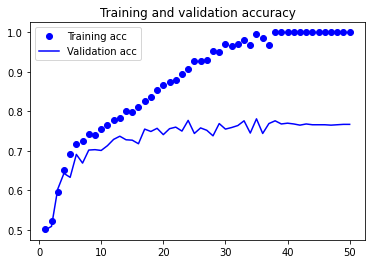

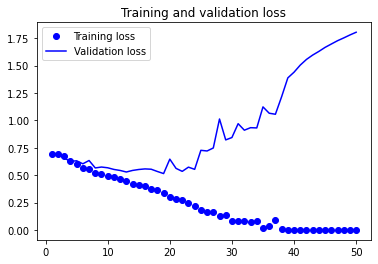

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

> ### (50pts) Improve the baseline model
* Try at least three strategies to improve the validation performance of the baseline model.
* You should examine that the performance is indeed improved as you employ your strategies. In other words, you should show that (accuracy with strategy 1 <= accuracy with strategy 1 and 2 <= accuracy with strategy 1, 2, and 3).

>> ### (15pts) Trial 1: Data augmentetion to improve generalization

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


In [ ]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
100/100 [==============================] - 23s 227ms/step - loss: 0.7456 - acc: 0.5905 - val_loss: 0.6402 - val_acc: 0.6400
Epoch 2/50
100/100 [==============================] - 22s 217ms/step - loss: 0.6210 - acc: 0.6460 - val_loss: 0.5673 - val_acc: 0.7060
Epoch 3/50
100/100 [==============================] - 22s 215ms/step - loss: 0.5762 - acc: 0.6985 - val_loss: 0.5504 - val_acc: 0.7150
Epoch 4/50
100/100 [==============================] - 22s 215ms/step - loss: 0.5471 - acc: 0.7210 - val_loss: 0.5594 - val_acc: 0.7180
Epoch 5/50
100/100 [==============================] - 21s 214ms/step - loss: 0.5358 - acc: 0.7255 - val_loss: 0.5141 - val_acc: 0.7410
Epoch 6/50
100/100 [==============================] - 21s 212ms/step - loss: 0.5104 - acc: 0.7470 - val_loss: 0.5115 - val_acc: 0.7460
Epoch 7/50
100/100 [==============================] - 21s 213ms/step - loss: 0.4856 - acc: 0.7625 - val_loss: 0.5012 - val_acc: 0.7640
Epoch 8/50
100/100 [==============================] - 2

In [ ]:
model.save('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_2.h5')

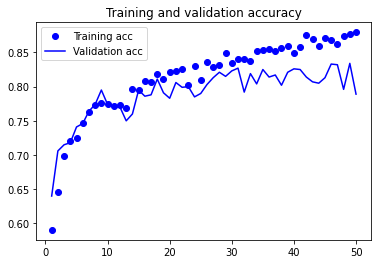

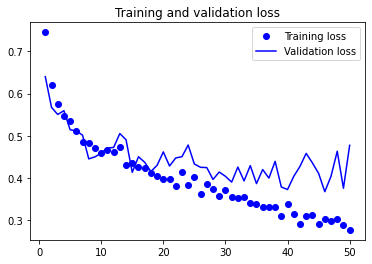

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

>> ### (15pts) Trial 2: trial1 + Model Checkpoint + ImageNet + FineTunning (frozen layers)

We need to tune-in data augmentation, because our approach was too strong comparable to the real data. In some runs we got higher accuracy on validation than on training, we can see a gap between validation and training. To prevent overfitting we will save the model not after last epoch but use ModelCheckpoint callback to save best model while looking at validation metric. Rather than using a random variables we should use pretrained weights from ImageNet.

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [5]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath='/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_trial_2.h5')


conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [7]:
conv_base.trainable = False # we freeze imagenet weights

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential() # we add our own layers on top of the base model
model.add(conv_base)
model.add(layers.AveragePooling2D(pool_size=(2, 2)))
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2)) # we add some dropout regularization
model.add(layers.Dense(2, activation='softmax')) # because we need to have two nodes as an output we must use softmax activation function, rather then sigmoid used for 1 

In [10]:
model.summary() # we check how many trainable and non-trainable parameters we have

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 2, 2, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [14]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-2), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [15]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=[modelckpt])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


100/100 [==============================] - 799s 8s/step - loss: 0.9345 - acc: 0.7565 - val_loss: 0.3268 - val_acc: 0.8670
Epoch 2/50
100/100 [==============================] - 22s 223ms/step - loss: 0.3677 - acc: 0.8320 - val_loss: 0.3138 - val_acc: 0.8700
Epoch 3/50
100/100 [==============================] - 21s 212ms/step - loss: 0.3336 - acc: 0.8515 - val_loss: 0.3037 - val_acc: 0.8700
Epoch 4/50
100/100 [==============================] - 22s 220ms/step - loss: 0.3269 - acc: 0.8540 - val_loss: 0.3108 - val_acc: 0.8810
Epoch 5/50
100/100 [==============================] - 22s 223ms/step - loss: 0.2993 - acc: 0.8655 - val_loss: 0.3227 - val_acc: 0.8680
Epoch 6/50
100/100 [==============================] - 21s 210ms/step - loss: 0.3125 - acc: 0.8680 - val_loss: 0.3174 - val_acc: 0.8720
Epoch 7/50
100/100 [==============================] - 21s 211ms/step - loss: 0.2844 - acc: 0.8760 - val_loss: 0.3156 - val_acc: 0.8750
Epoch 8/50
100/100 [==============================] - 21s 212ms/step

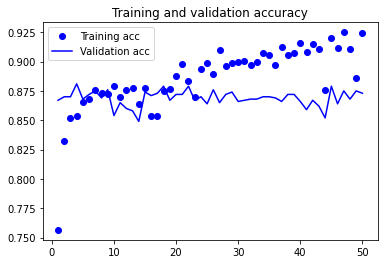

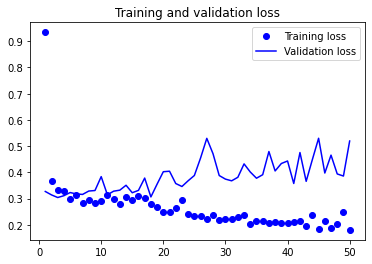

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

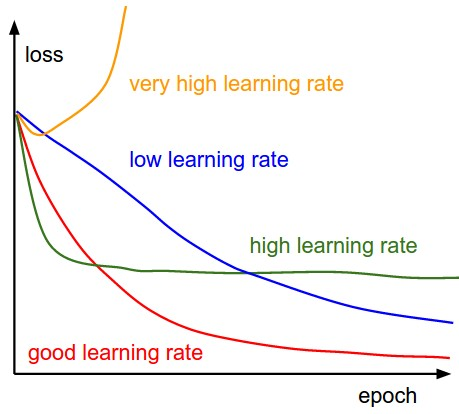

As we can see we have a high learning rate. We need to adjust it. Maybe we should also lower the dropout rate.

In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential() # we add our own layers on top of the base model
model.add(conv_base)
model.add(layers.AveragePooling2D(pool_size=(2, 2)))
model.add(layers.Flatten()) # we must flatten the convolution layers to 1D array for Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.05)) # we add some dropout regularization
model.add(layers.Dense(2, activation='softmax')) # because we need to have two nodes as an output we must use softmax activation function, rather then sigmoid used for 1 

In [22]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [23]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=[modelckpt])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


100/100 [==============================] - 52s 223ms/step - loss: 0.6784 - acc: 0.5715 - val_loss: 0.5989 - val_acc: 0.7050
Epoch 2/50
100/100 [==============================] - 21s 207ms/step - loss: 0.5800 - acc: 0.6990 - val_loss: 0.5282 - val_acc: 0.7730
Epoch 3/50
100/100 [==============================] - 21s 215ms/step - loss: 0.5226 - acc: 0.7600 - val_loss: 0.4788 - val_acc: 0.8100
Epoch 4/50
100/100 [==============================] - 21s 206ms/step - loss: 0.4826 - acc: 0.7840 - val_loss: 0.4428 - val_acc: 0.8210
Epoch 5/50
100/100 [==============================] - 21s 206ms/step - loss: 0.4568 - acc: 0.8005 - val_loss: 0.4155 - val_acc: 0.8380
Epoch 6/50
100/100 [==============================] - 21s 209ms/step - loss: 0.4310 - acc: 0.8040 - val_loss: 0.3946 - val_acc: 0.8510
Epoch 7/50
100/100 [==============================] - 21s 207ms/step - loss: 0.4053 - acc: 0.8255 - val_loss: 0.3798 - val_acc: 0.8500
Epoch 8/50
100/100 [==============================] - 22s 218ms/st

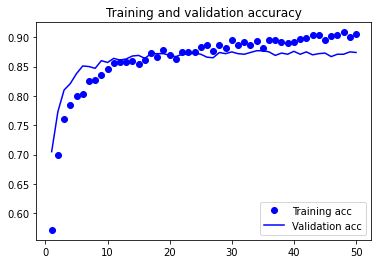

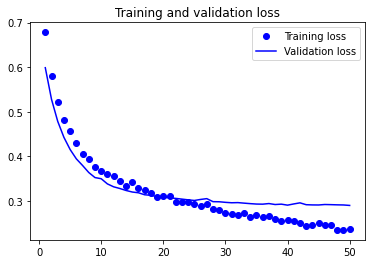

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

As we can see from the figure we obtained a good learning curve.

>> ### (20pts) Trial 3: trial1 + trial2 + Unfreezing the base model layers and using small learning rate we try to further improve our model's performance

https://keras.io/guides/transfer_learning/

In [25]:
conv_base.trainable = True # we unfreeze imagenet weights
model.summary() # we check how many trainable and non-trainable parameters we have

# save best epoch before it starts to overfit
modelckpt = ModelCheckpoint(
    monitor = 'val_acc',
    save_best_only=True,
    filepath='/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_trial_3.h5')



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 average_pooling2d_1 (Averag  (None, 2, 2, 512)        0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                      

In [26]:
model.compile(optimizer=Adam(learning_rate=1e-7), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=[modelckpt])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


100/100 [==============================] - 27s 232ms/step - loss: 0.2351 - acc: 0.9055 - val_loss: 0.2859 - val_acc: 0.8760
Epoch 2/50
100/100 [==============================] - 25s 248ms/step - loss: 0.2295 - acc: 0.9120 - val_loss: 0.2825 - val_acc: 0.8780
Epoch 3/50
100/100 [==============================] - 26s 263ms/step - loss: 0.2208 - acc: 0.9160 - val_loss: 0.2785 - val_acc: 0.8800
Epoch 4/50
100/100 [==============================] - 24s 236ms/step - loss: 0.2227 - acc: 0.9100 - val_loss: 0.2753 - val_acc: 0.8820
Epoch 5/50
100/100 [==============================] - 22s 222ms/step - loss: 0.2157 - acc: 0.9160 - val_loss: 0.2729 - val_acc: 0.8820
Epoch 6/50
100/100 [==============================] - 24s 238ms/step - loss: 0.2121 - acc: 0.9120 - val_loss: 0.2700 - val_acc: 0.8850
Epoch 7/50
100/100 [==============================] - 24s 244ms/step - loss: 0.2110 - acc: 0.9205 - val_loss: 0.2673 - val_acc: 0.8880
Epoch 8/50
100/100 [==============================] - 24s 239ms/st

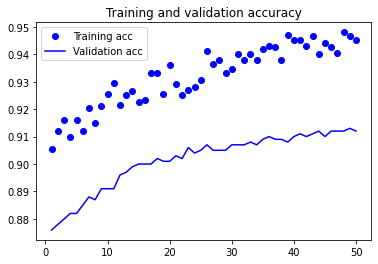

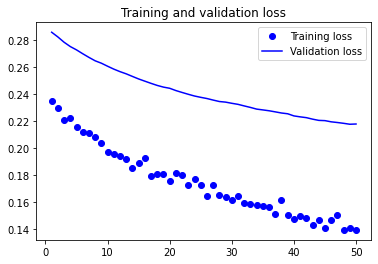

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

> ### (10pts) Compare the final performance of your models on the test dataset
  * Examine the final performance of the baseline, trial1, trial2, and trial3 models.
  * Verify the performance is improved as you apply some regularization methods. If not, discuss why.


In [31]:
from tensorflow.keras import models


baseline = models.load_model('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_1.h5')
trial_1 = models.load_model('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_2.h5')
trial_2_lost = models.load_model('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_3.h5')
trial_2 = models.load_model('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_trial_2.h5')
trial_3 = models.load_model('/content/gdrive/MyDrive/Artificial_Intelligence/dogs_and_cats_trial_3.h5')

baseline.evaluate(test_generator)
trial_1.evaluate(test_generator)
trial_2_lost.evaluate(test_generator)
trial_2.evaluate(test_generator)
trial_3.evaluate(test_generator)

50/50 [==============================] - 5s 89ms/step - loss: 0.2127 - acc: 0.9130


[0.21267881989479065, 0.9129999876022339]

As it can be see every improvement except for the trial 1 achieved better accuracy than a baseline model. Trial 1 used really strong data augmentation which might be a reason for a lower score. 

Best score achieved model which was unfortunately lost. For some reason Google Colab didn't saved the updated version of assignment3.ipynb file. As it can be seen last edition was on 26.10 even though there are models from 27.10

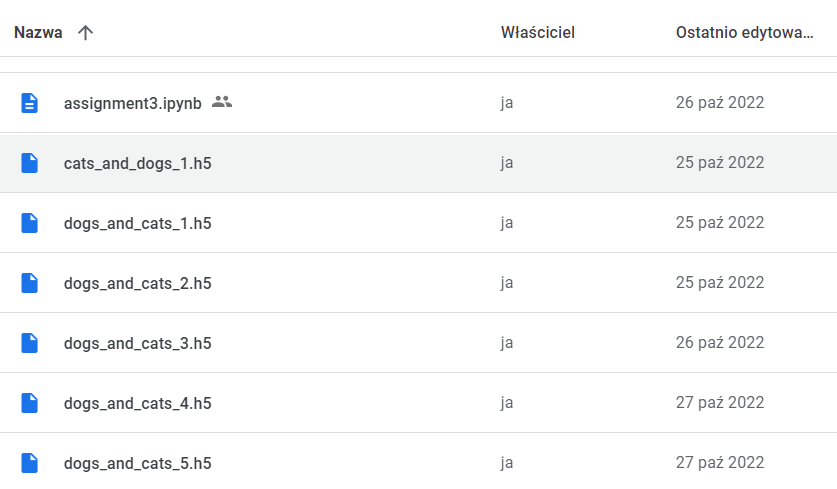

Only thing which I was able to present is a screen of begining of fiting. As we can see both in training and validation this model was able to achieve 95% accuracy.

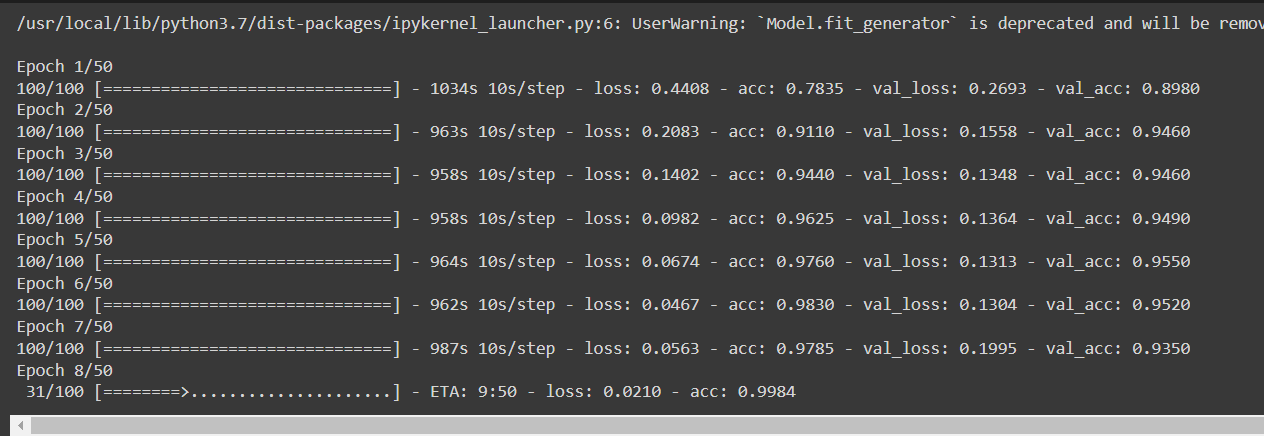

But because I don't have an access to the history I cannot plot this model. New presented achieved 86% and 91% accuracy, meaning that every trial gain +5p.p increase in accuracy. 